# Model-based RL: Two step task

The two step task is one of the most iconic tasks in RL (see Daw, ..., Dolan, Neuron 2011 for details). There are a lot of facets to it. Here, we will only focus on the behaviour of the model-free learner.

This code is based on the excellent paper from Thomas Akam, Rui Costa and Peter Dayan (PLOS Computational Biology, 2015): https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004648#sec002. This is a great ressource for learning many more things about the two-step task and possible ways to model it and fit parameters.

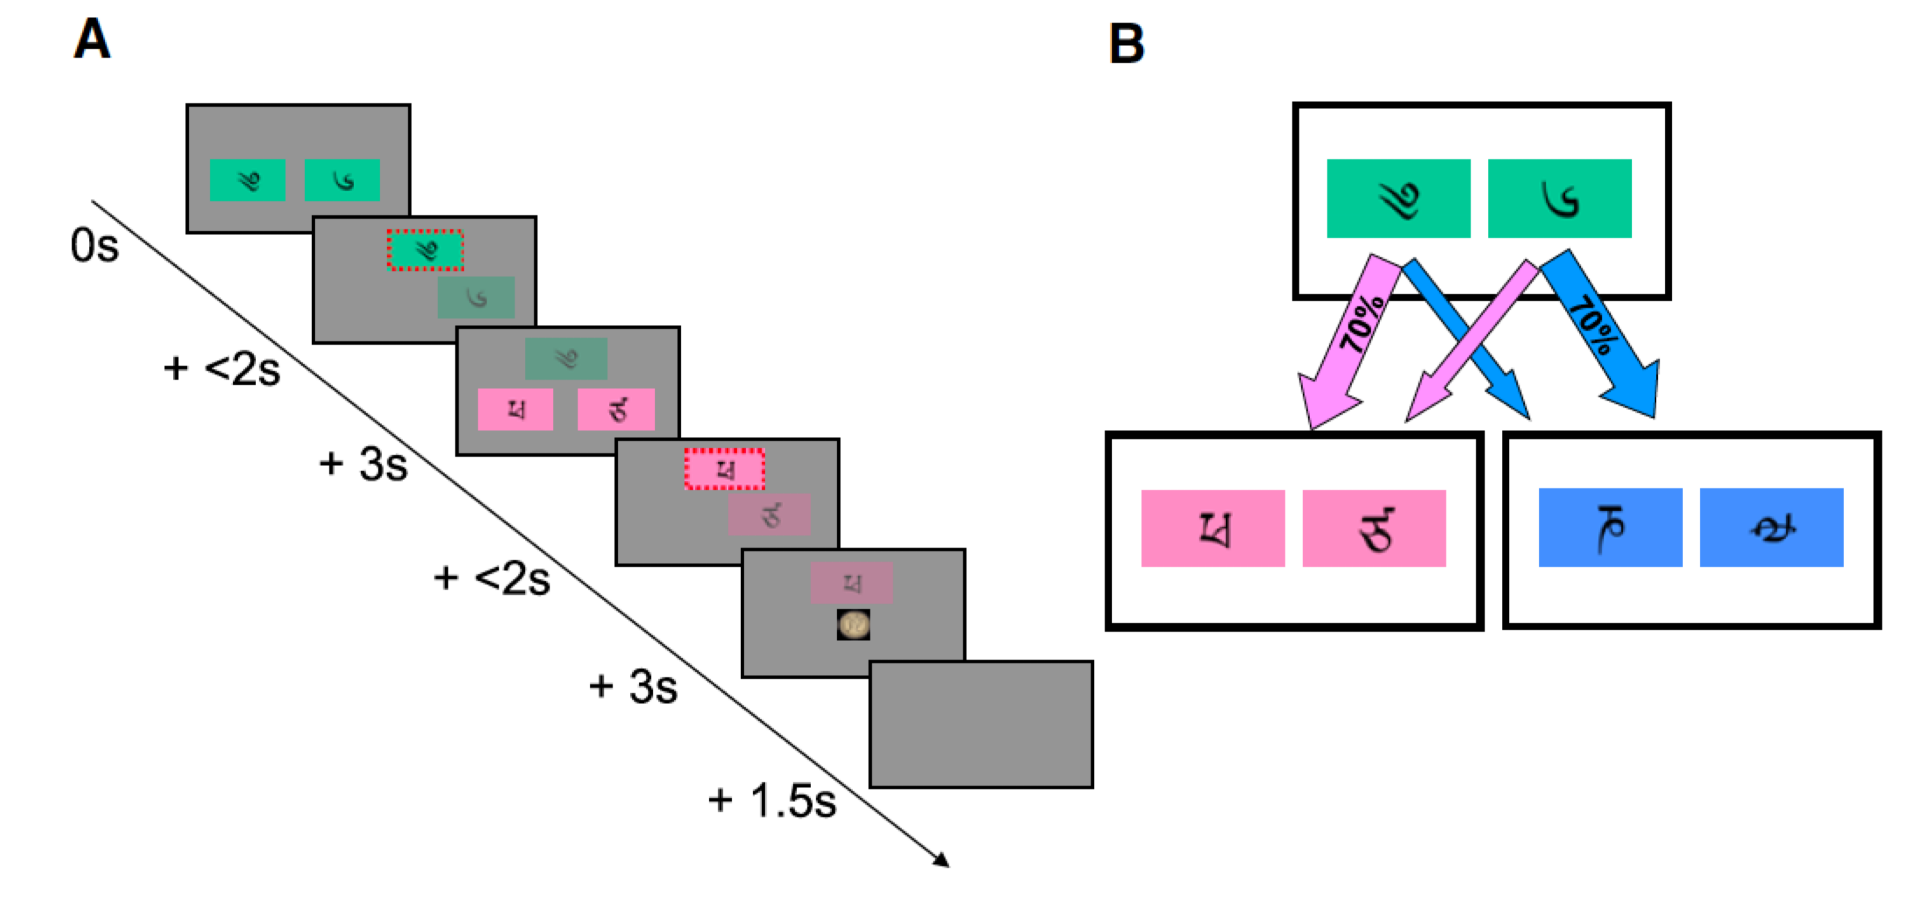

The key idea of the task is to have participants make decisions at **two time steps** (green: time step 1, pink/blue: time step 2). Every choice in the first (green) level will bring subjects to either the pink or blue level. Importantly: each of the two green first-level options as a **common** and **rare** **transition**, meaning that they usually lead to either pink or blue, but sometimes to the opposite colour.

When entering the second-level (pink or blue), subjects have to choose one of the available options and will receive a reward with a certain probability.

As we will see below, this task is interesting because it differentiates a **model-free** from a **model-based** learner. In essence, a model-free learner will simply repeat whatever has been rewarded in the past, whereas a model-based learner will incorporate the transition-probabilities (common vs. rare) to only repeat actions that will likely lead to reward.

In this notebook, you have to solve three tasks:


*   Implement the learning of the first level Q-values in the model-free agent
*   Implement the learning of the first level Q-values in the model-based agent
*   Implement the learning of the first level Q-values in the mixed (model-free and model-based) agent, and the weighting between those two
*   Explore and describe the role of different parameters, especially $\alpha$, $\beta$, and w

We start with the usual imports and defining some helper functions.

In [37]:
# Imports
import numpy as np                 
import matplotlib.pyplot as plt
from random import random, randint
import sys

log_max_float = np.log(sys.float_info.max/2.1) # Log of largest possible floating point number.

In [38]:
# @title Helper functions

def choose(P):
  
  "Takes vector of probabilities P summing to 1, returns integer s with prob P[s]"

  return sum(np.cumsum(P) < random())

def softmax(Q,T):
  
  "Softmax choice probs given values Q and inverse temp T."

  QT = Q * T
  QT[QT > log_max_float] = log_max_float # Protection against overflow in exponential.    
  expQT = np.exp(QT)

  return expQT/expQT.sum()

def gauss_rand_walks(n_trials, step_SD, p_range = [0, 1], n_walks = 2):
  
  'Generate a set of reflecting Gaussian random walks.'
  
  walks = np.random.normal(scale = step_SD, size = (n_trials, n_walks))
  walks[0,:] = np.random.rand(n_walks)
  walks = np.cumsum(walks, 0)
  walks = np.mod(walks, 2.)
  walks[walks > 1.] = 2. - walks[walks > 1.]
  
  if p_range != [0, 1]:
      walks = walks  * (p_range[1]- p_range[0]) + p_range[0]
  
  return walks

def fixed_length_blocks(n_trials, probs, block_length):
  
  'Reversals in reward probabilities every block_length_trials.'
  
  block_1 = np.tile(probs,(block_length,1))
  block_2 = np.tile(probs[::-1],(block_length,1))
  
  return np.tile(np.vstack([block_1,block_2]), \
          (np.ceil(n_trials / (2. * block_length)),1,))[:n_trials,:]

def task_stats(n_trials = 1000,rew_gen = 'walks',step_SD = 0.025):
  
  'Generate a fresh set of reward probabilities.'

  if rew_gen == 'walks':   
      reward_probs  = gauss_rand_walks(n_trials, step_SD, p_range = [0.25, 0.75],
                                              n_walks = 4).reshape(n_trials,2,2)
  elif rew_gen == 'blocks':
      reward_probs = np.tile(fixed_length_blocks(n_trials, [0.2,0.8], 50 
                                  ).reshape(n_trials,2,1),[1,1,2])  
  rew_prob_iter = iter(reward_probs)

  return reward_probs, rew_prob_iter

def first_step(choice,com_prob = 0.7):
  'Given first step choice generate second step.'
  transition  = int(random() <  com_prob)   # 1 if common, 0 if rare.
  second_step = int(choice == transition)        # Choice 1 (0) commonly leads to second_step 1 (0).
  return second_step, transition

def second_step(second_step, choice_2,rew_prob_iter):
  outcome = int(random() < next(rew_prob_iter)[second_step, choice_2])
  return outcome

from scipy.stats import sem, ttest_rel

def setup_figure(fig_no = 1, clf = True):
  plt.figure(fig_no)
  if clf:plt.clf()

def stay_prob_plot(stay_probs, fig_no = 1, clf = True):
  'Plot stay probabilities with SEM errorbars for a list of sessions.'
  setup_figure(fig_no, clf)
  plt.bar(np.arange(1,5), np.mean(stay_probs,0), yerr = sem(stay_probs,0),
          error_kw = {'ecolor': 'r', 'capsize': 5, 'elinewidth': 5})
  plt.ylim(0,1)
  plt.xlim(0,5)
  plt.xticks([1,2,3,4],['Reward \n Common', 'Reward \n Rare', 'No Reward \n Common', 'No Reward \n Rare'])
  plt.ylabel('Stay Probability')

# Part 1: Define a model-free Q-Learner in the two-step task

## Task 1: Implement the learning of the first level Q-values in the model-free agent

Model-free learning here simply means that agents have a tendency to repeat whatever was rewarded previously. Let's see what this looks like:

In [63]:
def simulate_MF(n_trials = 1000, alpha=0.1, beta=5):

  # initialise variables:
  Q_td_1 = np.zeros(2)     # First step action values.
  Q_td_2 = np.zeros([2,2]) # Second step action values, indicies: [state, action]

  choices_1, second_steps, choices_2, rewards, transitions = (np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int))

  # initialise task statistics:
  reward_probs, rew_prob_iter = task_stats(n_trials)

  for i in range(n_trials):
    # Generate trial events.
    choice_1      = choose(softmax(Q_td_1, beta))      # First step action.
    next_state, t = first_step(choice_1)               # Find second step state.
    choice_2      = choose(softmax(Q_td_2[next_state,:], beta)) # Second_step action.
    reward        = second_step(next_state, choice_2, rew_prob_iter)            # Trial outcome.   

    # update action values
    # second time step
    Q_td_2[next_state,choice_2] = Q_td_2[next_state,choice_2] + alpha * (reward - Q_td_2[next_state,choice_2])

    # first time step
    # YOUR CODE HERE
    #  hint: same structure as the learning of Q_td_2, except there is no next_state variable
    # Q_td_1[choice_1] = ...

    choices_1[i], second_steps[i], choices_2[i], rewards[i], transitions[i]  = (choice_1, next_state, choice_2, reward, t)

  return choices_1, second_steps, choices_2, rewards, transitions

Take a minute to go through the code and see if you can see what's going on. Do you remember what the parameters $\alpha$ and $\beta$ are doing?

Now let's have a look what the simulation looks like:

Behaviour MF agent:


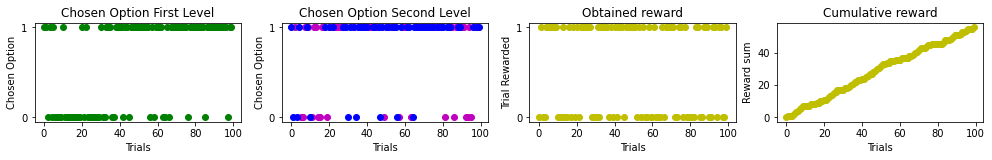

In [64]:
# @title Run to simulate behaviour
print("Behaviour MF agent:")

choices_1, second_steps, choices_2, rewards, _ = simulate_MF(n_trials = 100)

plt.rcParams['figure.figsize'] = [17, 4]
rows = 2
cols = 4
fig = plt.figure() 

fig_count = 1
fig.add_subplot(rows, cols, fig_count)
plt.plot(choices_1,'go')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option First Level')

idx_2_0 = np.where(second_steps==0)[0]
idx_2_1 = np.where(second_steps==1)[0]
trls = np.arange(len(second_steps))

fig_count = 2
fig.add_subplot(rows, cols, fig_count)
plt.plot(trls[idx_2_0],choices_2[idx_2_0],'mo')
plt.plot(trls[idx_2_1],choices_2[idx_2_1],'bo')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option Second Level')

fig_count = 3
fig.add_subplot(rows, cols, fig_count)
plt.plot(rewards,'yo')
plt.xlabel('Trials')
plt.ylabel('Trial Rewarded')
plt.yticks([0,1])
plt.title('Obtained reward')

fig_count = 4
fig.add_subplot(rows, cols, fig_count)
plt.plot(np.cumsum(rewards),'yo')
plt.xlabel('Trials')
plt.ylabel('Reward sum')
plt.title('Cumulative reward')

plt.show()

# Part 2: Get 'Stay Probabilities'

We can now analyse the 'stay probabilities' for the first level choice and the model-free Q-learner. First, let's compute them:

In [65]:
def session_stay_probs(choices_1=[],transitions=[],rewards=[]):
  
  'Evaluate stay probabilities for a single session'

  if len(choices_1)==0:
    choices_1, _, _, rewards, transitions = simulate_MF(n_trials = 100)

  # stay = current first-level choice is same as in previous trial
  stay = choices_1[1:] == choices_1[:-1]

  stay_probs = np.zeros(4)

  idx_RewComm  = np.logical_and(transitions[:-1]==1, rewards[:-1]==1)
  idx_RewRare  = np.logical_and(transitions[:-1]==0, rewards[:-1]==1)
  idx_NRewComm = np.logical_and(transitions[:-1]==1, rewards[:-1]==0)
  idx_NRewRare = np.logical_and(transitions[:-1]==0, rewards[:-1]==0)

  stay_probs[0] = np.mean(stay[idx_RewComm]) # Rewarded, common transition.
  stay_probs[1] = np.mean(stay[idx_RewRare]) # Rewarded, rare transition.
  stay_probs[2] = np.mean(stay[idx_NRewComm]) # Non-rewarded, common transition.
  stay_probs[3] = np.mean(stay[idx_NRewRare]) # Non-rewarded, rare transition.

  return stay_probs

Session 0 of 10 done.
Session 1 of 10 done.
Session 2 of 10 done.
Session 3 of 10 done.
Session 4 of 10 done.
Session 5 of 10 done.
Session 6 of 10 done.
Session 7 of 10 done.
Session 8 of 10 done.
Session 9 of 10 done.


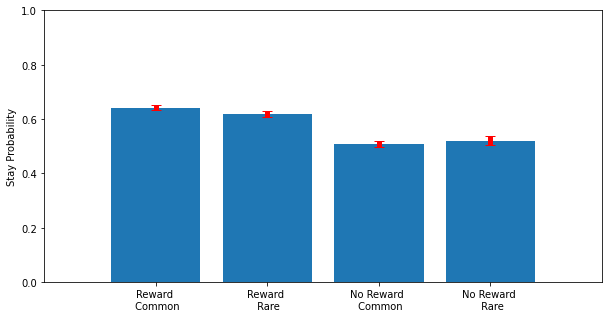

In [66]:
# @title Run to get stay probabilities
n_sessions = 10    # Number of sessions per agent.
n_trials   = 1000  # Number of trials per session.

stay_probs = np.zeros((n_sessions,4))

for idx_sess in np.arange(n_sessions):
  choices_1, _, _, rewards, transitions = simulate_MF(n_trials)
  stay_probs[idx_sess,:] = session_stay_probs(choices_1,transitions,rewards)

  print("Session " + str(idx_sess) + " of " + str(n_sessions) + " done.")

plt.rcParams['figure.figsize'] = [10, 5]
stay_prob_plot(stay_probs) # this is a helper function to plot from above

# Part 3: Define a model-based Q-Learner in the two-step task

## Task 2: Implement the learning of the first level Q-values in the model-based agent

In contrast to a model-free learner, a model-based learner incorporates its knowledge about the transition statistics into its learning.

Has it been rewarded after a rare transition? It should then take the option that leads to the previously rewarded outcome with a **common transition**!

In [67]:
def simulate_MB(n_trials = 1000, alpha=0.1, beta=5):

  # initialise variables:
  transition = np.zeros(n_trials)

  Q_mb   = np.zeros(2)      # Model based action values - at first-level!

  Q_td_2 = np.zeros([2,2])  # Second_step action values, indicies: [state, action]

  choices_1, second_steps, choices_2, rewards, transitions = (np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int))

  # initialise task statistics:
  reward_probs, rew_prob_iter = task_stats(n_trials)

  for i in range(n_trials):
    # Generate trial events.
    choice_1      = choose(softmax(Q_mb, beta))   # First_step action (model-based)
    next_state, t = first_step(choice_1)          # Second step state.

    choice_2 = choose(softmax(Q_td_2[next_state,:], beta)) # Second_step action.
    reward   = second_step(next_state, choice_2, rew_prob_iter) # Trial outcome.  

    # Update action values.
    # At second time-step:
    Q_td_2[next_state,choice_2] = Q_td_2[next_state,choice_2] + alpha * (reward - Q_td_2[next_state,choice_2])

    # At first time-step:
    # YOUR CODE HERE
    #  hints: 
    # Q_s is the maximum over Q_td_2 across choice_2S
    # Q_mb is a mixture of Q_s weighted by rare and common transitions
    # Q_s  = ... # State values are max action value available in each state.
    # Q_mb = common_P * Q_s + rare_P * Q_s[::-1]

    choices_1[i], second_steps[i], choices_2[i], rewards[i], transitions[i]  = (choice_1, next_state, choice_2, reward, t)

  return choices_1, second_steps, choices_2, rewards, transitions

Behaviour MB agent:


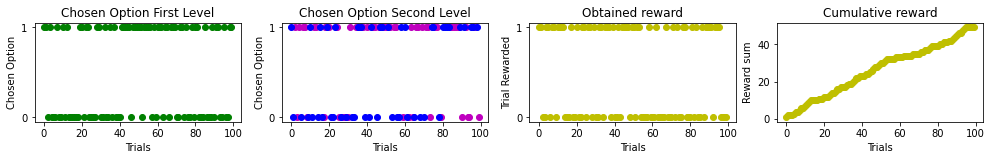

In [68]:
# @title Run to simulate behaviour
print("Behaviour MB agent:")

choices_1, second_steps, choices_2, rewards, _ = simulate_MB(n_trials = 100)

plt.rcParams['figure.figsize'] = [17, 4]
rows = 2
cols = 4
fig = plt.figure() 

fig_count = 1
fig.add_subplot(rows, cols, fig_count)
plt.plot(choices_1,'go')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option First Level')

idx_2_0 = np.where(second_steps==0)[0]
idx_2_1 = np.where(second_steps==1)[0]
trls = np.arange(len(second_steps))

fig_count = 2
fig.add_subplot(rows, cols, fig_count)
plt.plot(trls[idx_2_0],choices_2[idx_2_0],'mo')
plt.plot(trls[idx_2_1],choices_2[idx_2_1],'bo')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option Second Level')

fig_count = 3
fig.add_subplot(rows, cols, fig_count)
plt.plot(rewards,'yo')
plt.xlabel('Trials')
plt.ylabel('Trial Rewarded')
plt.yticks([0,1])
plt.title('Obtained reward')

fig_count = 4
fig.add_subplot(rows, cols, fig_count)
plt.plot(np.cumsum(rewards),'yo')
plt.xlabel('Trials')
plt.ylabel('Reward sum')
plt.title('Cumulative reward')

plt.show()

Session 0 of 10 done.
Session 1 of 10 done.
Session 2 of 10 done.
Session 3 of 10 done.
Session 4 of 10 done.
Session 5 of 10 done.
Session 6 of 10 done.
Session 7 of 10 done.
Session 8 of 10 done.
Session 9 of 10 done.


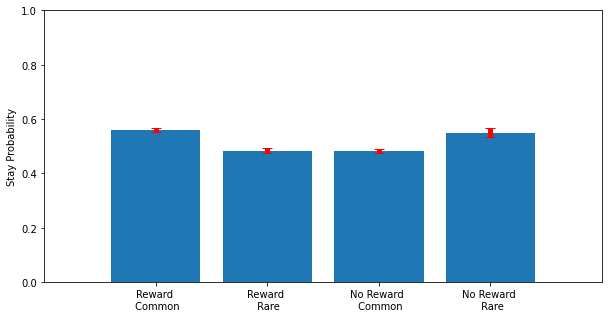

In [69]:
# @title Run to get stay probabilities
n_sessions = 10     # Number of sessions per agent.
n_trials   = 1000  # Number of trials per session.

stay_probs = np.zeros((n_sessions,4))

for idx_sess in np.arange(n_sessions):
  choices_1, second_steps, choices_2, rewards, transitions = simulate_MB(n_trials)
  stay_probs[idx_sess,:] = session_stay_probs(choices_1,transitions,rewards)

  print("Session " + str(idx_sess) + " of " + str(n_sessions) + " done.")

plt.rcParams['figure.figsize'] = [10, 5]
stay_prob_plot(stay_probs) # this is a helper function to plot from above

The above plot reproduces the model-based action probabilities from the main paper. Can you tell what's the key difference in the simulate_MB code that produces 'model-based' Q-values?

Can you see a performance difference between a model-free and model-based agent?

# Part 4: Model-free and model-based learning in the two-step task

## Task 3: Implement the learning of the first level Q-values in the mixed (model-free and model-based) agent, and the weighting between those two

Studies tend to find that empirical behaviour is a mix of model-free and model based behaviour. The following function defines one way of achieving this mix via a **weighting** between a MF and MB controller:

In [76]:
def simulate_MFMB(n_trials = 1000, alpha=0.1, beta=10, w=0.5):

  Q_mb   = np.zeros(2)      # Model-based (first-step) action values
  Q_td_1 = np.zeros(2)      # First step action values

  Q_td_2 = np.zeros([2,2])  # Second_step action values, indicies: [state, action]

  choices_1, second_steps, choices_2, rewards, transitions = (np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int), np.zeros(n_trials, int))

  # initialise task statistics:
  reward_probs, rew_prob_iter = task_stats(n_trials)

  for i in range(n_trials):
    # Generate trial events.
    # YOUR CODE HERE
    # hint: this is a weighted average of Q_mb and Q_td_1, weighted by w and (1-w) respectively
    # weighted_Q = ...

    choice_1      = choose(softmax(weighted_Q, beta)) # First_step action.
    next_state, t = first_step(choice_1)              # Second step state.

    choice_2 = choose(softmax(Q_td_2[next_state,:], beta)) # Second_step action.
    reward   = second_step(next_state, choice_2, rew_prob_iter) # Trial outcome.  

    # update action values.
    # At first time-step (model-free):
    # YOUR CODE HERE
    # hint: same as above
    # Q_td_1[choice_1] = ...

    # At first time-step (model-based):
    # YOUR CODE HERE
    # hint: same as above
    # Q_s = ... # State values are max action value available in each state.
    # Q_mb   = ...

    # At second time-step:
    Q_td_2[next_state,choice_2] = Q_td_2[next_state,choice_2] + alpha * (reward - Q_td_2[next_state,choice_2])

    choices_1[i], second_steps[i], choices_2[i], rewards[i], transitions[i]  = (choice_1, next_state, choice_2, reward, t)

  return choices_1, second_steps, choices_2, rewards, transitions

Behaviour MF + MB agent:


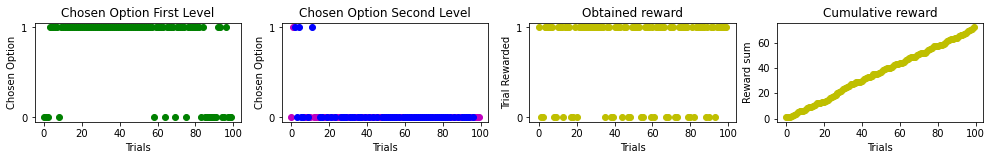

In [77]:
# @title Run to simulate behaviour
print("Behaviour MF + MB agent:")

choices_1, second_steps, choices_2, rewards, _ = simulate_MFMB(n_trials = 100)

plt.rcParams['figure.figsize'] = [17, 4]
rows = 2
cols = 4
fig = plt.figure() 

fig_count = 1
fig.add_subplot(rows, cols, fig_count)
plt.plot(choices_1,'go')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option First Level')

idx_2_0 = np.where(second_steps==0)[0]
idx_2_1 = np.where(second_steps==1)[0]
trls = np.arange(len(second_steps))

fig_count = 2
fig.add_subplot(rows, cols, fig_count)
plt.plot(trls[idx_2_0],choices_2[idx_2_0],'mo')
plt.plot(trls[idx_2_1],choices_2[idx_2_1],'bo')
plt.xlabel('Trials')
plt.ylabel('Chosen Option')
plt.yticks([0,1])
plt.title('Chosen Option Second Level')

fig_count = 3
fig.add_subplot(rows, cols, fig_count)
plt.plot(rewards,'yo')
plt.xlabel('Trials')
plt.ylabel('Trial Rewarded')
plt.yticks([0,1])
plt.title('Obtained reward')

fig_count = 4
fig.add_subplot(rows, cols, fig_count)
plt.plot(np.cumsum(rewards),'yo')
plt.xlabel('Trials')
plt.ylabel('Reward sum')
plt.title('Cumulative reward')

plt.show()

Session 0 of 10 done.
Session 1 of 10 done.
Session 2 of 10 done.
Session 3 of 10 done.
Session 4 of 10 done.
Session 5 of 10 done.
Session 6 of 10 done.
Session 7 of 10 done.
Session 8 of 10 done.
Session 9 of 10 done.


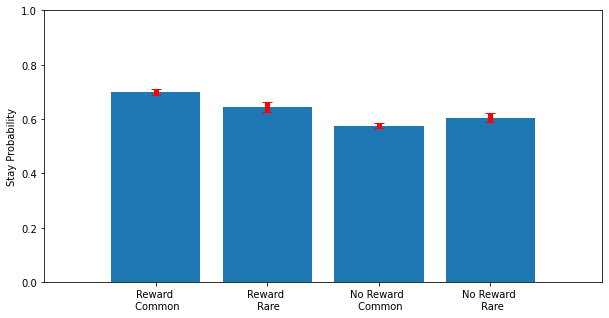

In [78]:
# @title Run to get stay probabilities
n_sessions = 10   # Number of sessions per agent.
n_trials   = 1000  # Number of trials per session.

stay_probs = np.zeros((n_sessions,4))

for idx_sess in np.arange(n_sessions):
  choices_1, _, choices_2, rewards, transitions = simulate_MFMB(n_trials)
  stay_probs[idx_sess,:] = session_stay_probs(choices_1,transitions,rewards)

  print("Session " + str(idx_sess) + " of " + str(n_sessions) + " done.")

plt.rcParams['figure.figsize'] = [10, 5]
stay_prob_plot(stay_probs) # this is a helper function to plot from above

The above replicates the empirical results found in the original (and many following) paper(s). Can you figure out what happens in the simulate_MFMB code, and which parameter governs the trade-off between model-free and model-based behaviour? What happens if that parameter takes more extreme values (e.g. 0 or 1)? 

## Task 4: Explore and describe the role of different parameters, especially $\alpha$, $\beta$, and w